# Examples of using HTOF:
### This notebook contains a variety of use case examples for htof.

## Example 1: Simple fit to hip 2007 astrometry of beta pic.

#### First way: Using the Astrometry() convienience class (no parallax)

In [1]:
from astropy.time import Time
from astropy.coordinates import Angle
import numpy as np
from htof.main import Astrometry
import os


# Note that including the parallax component is important if you want to recover the catalog errors.
pmRA = 4.65  # mas/year
pmDec = 81.96  # mas/year
# generate fitter and parse intermediate data
astro = Astrometry('Hip21', '27321', os.path.join('htof/test/data_for_tests/', 'Hip21'), 
                   central_epoch_ra=1991.25,
                   central_epoch_dec=1991.25, format='jyear', fit_degree=1,
                   use_parallax=False)
# generate ra and dec for each observation.
centered_epochs = Time(astro.data.julian_day_epoch(), format='jd', scale='tcb').jyear - \
                  Time(1991.25, format='decimalyear').jyear
ra = Angle(pmRA * centered_epochs, unit='mas')
dec = Angle(pmDec * centered_epochs, unit='mas')
# add residuals
ra += Angle(astro.data.residuals.values * np.sin(astro.data.scan_angle.values), unit='mas')
dec += Angle(astro.data.residuals.values * np.cos(astro.data.scan_angle.values), unit='mas')
#
solution_vector = astro.fit(ra.mas, dec.mas)
print(f'four parameter fit to Hip Javatool data:')
print('proper motion in ra (mas/yr), proper motion in dec (mas/yr)')
ra0, dec0, mu_ra, mu_dec = solution_vector
print(mu_ra.round(4), mu_dec.round(4))

four parameter fit to Hip Javatool data:
proper motion in ra (mas/yr), proper motion in dec (mas/yr)
4.6504 81.9591


#### Second way: Separately using data parsers and the fitter class

In [2]:
from htof.parse import HipparcosRereductionDVDBook, HipparcosRereductionJavaTool
from htof.fit import AstrometricFitter

iad_name = 'Hip21'

parser = {'Hip2': HipparcosRereductionDVDBook, 'Hip21': HipparcosRereductionJavaTool}[iad_name]
data = parser()
data.parse(star_id=27321,
           intermediate_data_directory=os.path.join('htof/test/data_for_tests/', iad_name))
data.calculate_inverse_covariance_matrices()
# generate ra and dec for each observation.
jyear_epochs = Time(data.julian_day_epoch(), format='jd', scale='tcb').jyear
centered_epochs = jyear_epochs - Time(1991.25, format='decimalyear').jyear
ra = Angle(pmRA * centered_epochs, unit='mas')
dec = Angle(pmDec * centered_epochs, unit='mas')
# add residuals
ra += Angle(data.residuals.values * np.sin(data.scan_angle.values), unit='mas')
dec += Angle(data.residuals.values * np.cos(data.scan_angle.values), unit='mas')
#
fitter = AstrometricFitter(inverse_covariance_matrices=data.inverse_covariance_matrix,
                           epoch_times=jyear_epochs, central_epoch_dec=1991.25, central_epoch_ra=1991.25)
solution_vector = fitter.fit_line(ra.mas, dec.mas)
print(f'four parameter fit to {iad_name} data:')
print('proper motion in ra (mas/yr), proper motion in dec (mas/yr)')
ra0, dec0, mu_ra, mu_dec = solution_vector
print(mu_ra.round(4), mu_dec.round(4))

four parameter fit to Hip21 data:
proper motion in ra (mas/yr), proper motion in dec (mas/yr)
4.6504 81.9591


## Example 2: Combining astrometric missions for beta pic and extracting the best fit astrometric parameters from the two

In [3]:

from htof.parse import GaiaData, GaiaeDR3, HipparcosOriginalData, DataParser
from htof.fit import AstrometricFitter
from htof.sky_path import parallactic_motion, earth_ephemeris
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle
from astropy.constants import G
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# relevant star parameters
hip_id = '27321'
cntr_ra, cntr_dec = Angle(86.82118072, 'degree'), Angle(-51.06671341, 'degree')
plx = 1.1 * u.mas # fake parallax
# parse Hipparcos 1 data for hip 27321
hip1 = HipparcosOriginalData()
hip1.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/Hip1/IntermediateData')
hip1.calculate_inverse_covariance_matrices()

# parse Gaia EDR3.
gaia = GaiaeDR3()
gaia_err = 120/1000  # gaia single measurement error in milli arc second. Should be ~50 to 170 micro arc seconds.
gaia.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/GaiaeDR3')
gaia.along_scan_errs = pd.Series(np.ones(len(gaia), dtype=float) * gaia_err)
gaia.calculate_inverse_covariance_matrices()

# combine the two missions:
data = hip1 + gaia # combined mission data

## We are combining Gaia and Hipparcos astrometric missions here. Note that this should be used in an exploratory way or for mission forecasting. In detail one has to place these individual transits into a common reference frame first.

### We are creating fake data here with proper motions of .5 mas/yr in ra and 0.1 mas/yr in dec, and a parallax angle of 1.1 mas.

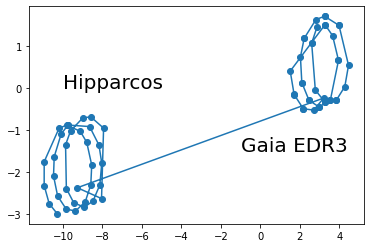

best fit astometric parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:
(mas, mas, mas, mas/yr, mas/yr)
[ 1.1 -0.  -0.   0.5  0.1]
Note that we have recovered the input proper motions and parallax.
standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:
[0.02888 0.1017  0.10572 0.01636 0.01683]
formal chisquared of the fit (will be near 0 because there is no noise):
1.4081286697388012e-11


In [4]:
# get the epochs for the fit
epochs = data.julian_day_epoch()

# generate the parallactic perturbations. For simplicity, assume ngrst and gaia and hipparcos are all in orbit
# around earth (even though Gaia is at L2). Really we would want to hstack the parallactic perturbations for each
# different ephemeris.
jyear_epoch = time.Time(epochs, format='jd', scale='tcb').jyear
# pick a central epoch for the fit:
central_epoch = 2010
ra_motion, dec_motion = parallactic_motion(jyear_epoch, cntr_ra.degree, cntr_dec.degree, 'degree',
                                           time.Time(central_epoch, format='decimalyear', scale='tcb').jyear,
                                           ephemeris=earth_ephemeris)
# ra_motion, dec_motion are the parallax motion alone, for a parallax of 1 mas. I.e., the parallax factors.
# note that ra_motion and dec_motion are in degrees here.
# generate sky path
year_epochs = jyear_epoch - time.Time(central_epoch, format='jyear', scale='tcb').jyear
# add a small linear motion (fake proper motion of beta pic) of 5 mas/yr in ra and .1 mas/yr in dec
ra = Angle(.5 * year_epochs, unit='mas') + Angle(ra_motion, unit='degree') * plx.value
dec = Angle(.1 * year_epochs, unit='mas') + Angle(dec_motion, unit='degree') * plx.value

# for large proper motions, ideally you will want to fit iteratively, because there are small numerical round offs
# that add up.

plt.figure()
plt.scatter(ra, dec)
plt.annotate('Hipparcos', xy=(-10, 0), fontsize=20)
plt.annotate('Gaia EDR3', xy=(-1, -1.5), fontsize=20)
plt.plot(ra, dec)
plt.show()

# now we fit with htof.fitter to solve for the proper motions (which will be equal to the input proper motions)
# fit_degree = 1 gives a standard 4 parameter fit (position + proper motions), or a 5 parameter fit (parallax, positions, proper motions) if 
# use_parallax=True and the parallactic components are given.
fitter = AstrometricFitter(data.inverse_covariance_matrix, jyear_epoch,
                           use_parallax=True, fit_degree=1, central_epoch_ra=central_epoch, 
                           central_epoch_dec=central_epoch,
                           parallactic_pertubations={'ra_plx': Angle(ra_motion, 'degree').mas,
                                                     'dec_plx': Angle(dec_motion, 'degree').mas})
# fit the standard model
astrometric_parameters, errors, chisquared = fitter.fit_line(ra.mas, dec.mas, return_all=True)
print('best fit astometric parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:')
print('(mas, mas, mas, mas/yr, mas/yr)')
print(astrometric_parameters.round(3))
print('Note that we have recovered the input proper motions and parallax.')
print('standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:')
print(errors.round(5))
print('formal chisquared of the fit (will be near 0 because there is no noise):')
print(chisquared)

## Lets also compute a variety of interesting parameters concerning this combined astrometric mission:

The covariance matrix of the five astrometric parameters:

In [5]:
covmat = fitter.evaluate_cov_matrix(central_epoch, central_epoch)
print(covmat)
print('note that the sqrt of the diagonal of the covariance matrix is equal to the standard errors on the parameters from the previous fit (as it should)')
print(list(np.sqrt(np.diagonal(covmat)).round(5)))
print('standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:')
print(errors.round(5))

[[ 8.34342863e-04 -5.58154324e-05  9.42265984e-05  2.01458530e-05
  -1.56400881e-05]
 [-5.58154324e-05  1.03438425e-02 -7.24140630e-04 -1.60236178e-03
   1.30613912e-04]
 [ 9.42265984e-05 -7.24140630e-04  1.11757135e-02  1.32448660e-04
  -1.71595818e-03]
 [ 2.01458530e-05 -1.60236178e-03  1.32448660e-04  2.67716832e-04
  -2.54324591e-05]
 [-1.56400881e-05  1.30613912e-04 -1.71595818e-03 -2.54324591e-05
   2.83135999e-04]]
note that the sqrt of the diagonal of the covariance matrix is equal to the standard errors on the parameters from the previous fit (as it should)
[0.02888, 0.1017, 0.10572, 0.01636, 0.01683]
standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:
[0.02888 0.1017  0.10572 0.01636 0.01683]


The epochs at which the covariance between ra/pm_ra and dec/pm_dec (position/proper motion) is zero. These are called the central epochs.

In [6]:
best_epoch_ra, best_epoch_dec = fitter.find_optimal_central_epoch(coordinate='ra'), fitter.find_optimal_central_epoch(coordinate='dec')
print(best_epoch_ra, best_epoch_dec)

2015.9852858659249 2016.060543990744


Now lets check by computing the covariance matrix with those ra and dec epochs, comparing it to the one we computed above with a central epoch of 2010 for both ra and dec.

In [7]:
covmatbest = fitter.evaluate_cov_matrix(best_epoch_ra, best_epoch_dec)  # we set the central epoch above to be 2010, and centered the times around it, so we want 0,0 here.
print(f'ra/pm_ra covariance at the central epoch {best_epoch_ra : 1f}:')
print(covmatbest[1, 3].round(11)) # rounding to the eleventh decimal
print('ra/pm_ra covariance at 2010:')
print(covmat[1, 3].round(11))

print(f'dec/pm_dec covariance at the central epoch {best_epoch_dec: 1f}:')
print(covmatbest[2, 4].round(11)) # rounding to the eleventh decimal
print('dec/pm_dec covariance at 2010:')
print(covmat[2, 4].round(11))

ra/pm_ra covariance at the central epoch  2015.985286:
0.0
ra/pm_ra covariance at 2010:
-0.00160236178
dec/pm_dec covariance at the central epoch  2016.060544:
0.0
dec/pm_dec covariance at 2010:
-0.00171595818


## These "central epochs" are very important when the astrometric modelling is crucial. For orbital fits like Gl 229 B, where the astrometric modelling comprises a significant portion of the mass error budget, we need to verify that using the GOST data tool is appropriate.

### Comparing the central epochs that htof computes from the GOST data, to those inferred from the Gaia EDR3 archive, will tell us if something is amiss with the GOST data and by how much.
### Note that this tells us only if the Gaia GOST approximation is wrong. If this test is passed, then there is nothing obviously wrong, but it does not guarantee that using the GOST data is correct per se... But we cannot do any better --- we will have to wait for the full IAD with gaia DR4 to do better.

### First lets compute the central epochs that we infer using the GOST predicted scans:

In [8]:
object_hip_id = 27321
gaia_epoch_ra, gaia_epoch_dec = 2016, 2016 # for EDR3 !


# instantiate a gaia edr3 fitter object (so that the inverse covariance matrix etc. are calculated)
gaiaedr3astro =  Astrometry('GaiaeDR3', str(object_hip_id), 'htof/test/data_for_tests/GaiaeDR3', 
                            central_epoch_ra=gaia_epoch_ra, central_epoch_dec=gaia_epoch_dec, format='jyear', 
                            fit_degree=1, use_parallax=False, normed=False)

# printing the central epoch that we get using htof and the Gaia GOST prediction for EDR3:
central_epoch = gaiaedr3astro.optimal_central_epochs()

### now we load in the actual EDR3 archive ra, dec, covariances etc (the fitted parameters) to compute what the central epoch for EDR3 should be IF we had the full IAD (which we do not!). If this is close to the gost value computed above, then we are OK for using htof in something like orbit fitting with orvara. 

## NOTE: you will need to pip install astroquery for this cell to work. Astroquery is not used anywhere in the source code of htof, so it is not a pre-installed requirement of the package.

In [9]:
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy import units

Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"  # Select early Data Release 3

def get_gaiaedr3_archive_table(source_name):
    # get coordinates of object from SIMBAD
    result_table = Simbad.query_object(source_name)
    ra, dec = result_table['RA'][0], result_table['DEC'][0]
    coordinate = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg),
                          frame='icrs', equinox='j2000',
                          obstime=Time(2000.0, format='decimalyear'))
    # use those coordinates to query gaia.
    results = Gaia.query_object(coordinate=coordinate, radius=10.0 * units.arcsec)
    if len(results) > 1:
        results = results[0]
    return results

print(f'RA: {np.round(central_epoch["ra"], 5)} \nDEC: {np.round(central_epoch["dec"], 5)}', ' are the htof + GOST predictions for central epochs.')

t = get_gaiaedr3_archive_table(f'HIP {object_hip_id}')
assert t['source_id'] == 4792774797545800832  # just a manual double check that we indeed did pull Beta pic.
# pm_pos_covariance / pm_variance
print('catalog:')
catalog_central_epoch_ra = 2016 - t['ra_error'] * t['pmra_error'] * t['ra_pmra_corr'] / (t['pmra_error']**2)
catalog_central_epoch_dec = 2016 - t['dec_error'] * t['pmdec_error'] * t['dec_pmdec_corr'] / (t['pmdec_error']**2)
print(f'RA: {np.round(catalog_central_epoch_ra[0], 5)} \nDEC: {np.round(catalog_central_epoch_dec[0], 5)}', ' are the values from the Gaia EDR3 Archive')
print('diffs:')
print(f'RA: {np.round(central_epoch["ra"] - catalog_central_epoch_ra[0], 5)} \nDEC: {np.round(central_epoch["dec"] - catalog_central_epoch_dec[0], 5)}', ' (years) are the differences')

RA: 2016.07952 
DEC: 2016.14972  are the htof + GOST predictions for central epochs.
catalog:
RA: 2016.0853271484375 
DEC: 2016.0126953125  are the values from the Gaia EDR3 Archive
diffs:
RA: -0.0058 
DEC: 0.13702  (years) are the differences


## The difference in RA is minimal (less than 2 days), but the difference in Dec is on the border of being substantial (about 0.1 years). Because the EDR3 baseline is 2.75 years, we can expect this to perhaps induce, naively, a systematic error of 0.1/2.75 = 3.6% . So in any orbital fit (say using orvara), you would want to investigate the detailed effect of this (if there even is any effect) if the mass or orbital parameter constraints are comparable to or better than 3.6%. 

## Example 3: Ad-hoc correction of a data corrupted Hip2 source (using the Java tool IAD)

In [10]:
# here we are going to just parse an hip2.1 (java tool iad) source. Parsing will automatically apply the ad-hoc correction if necessary.
# This works for all but 38 sources in the java tool (as of June 24 2021).
# An up to date list of the sources for which this does not work 
# can be found in htof/data/hip2_Javatool_flagged.txt
import os
from htof.parse import HipparcosRereductionJavaTool

test_data_directory = os.path.join(os.getcwd(), 'htof/test/data_for_tests/Hip21')
data = HipparcosRereductionJavaTool()
# get info on the IAD without doing any rejection:

iad_with_header, iad = data.parse(star_id=44050, intermediate_data_directory=test_data_directory, attempt_adhoc_rejection=True)
print('Although data is fixed, the IAD that are returned by data parser are untouched. Note that the last 3 along scan errors (last column) are repeated')
print(iad)
print('length of the iad:', len(iad))
print('last ten along scan errors from the uncorrected IAD:')
print(iad[6][-10:])

print('now lets look at the DataParser object, which is actually fixed.')
print('length of the fixed data:', len(data))
print('So the fixed data have 71 transits instead of 74, because the 3 bugged epochs have been removed, and orbits have been shuffled.')

Although data is fixed, the IAD that are returned by data parser are untouched. Note that the last 3 along scan errors (last column) are repeated
       0       1       2       3       4     5     6
0    310 -1.0292  0.1738 -0.0457  0.9990  2.56  2.71
1    310 -1.0292  0.1683 -0.0381  0.9993  0.15  2.62
2    310 -1.0292  0.1686 -0.0391  0.9992  3.04  2.49
3    311 -1.0281  0.1627 -0.0279  0.9996 -0.12  2.50
4    311 -1.0281  0.1582 -0.0216  0.9998 -4.89  3.22
..   ...     ...     ...     ...     ...   ...   ...
69  2014  1.0412 -0.6202  0.8170  0.5766 -4.13  4.76
70  2079  1.1201  0.6583 -0.4111  0.9116  3.38  3.19
71  2079  1.1201  0.6586 -0.4115  0.9114  3.29  4.74
72  2079  1.1201  0.6592 -0.4122  0.9111 -4.07  4.76
73  2079  1.1201  0.6590 -0.4120  0.9112  3.44  3.19

[74 rows x 7 columns]
length of the iad: 74
last ten along scan errors from the uncorrected IAD:
64    1.85
65    2.02
66    2.17
67    3.80
68    4.74
69    4.76
70    3.19
71    4.74
72    4.76
73    3.19
Name: 6, d

if you wanted to retrieve the ad-hoc corrected IAD itself (and not use htof any further), you would first parse the source with htof. Then call data.additional_rejected_epochs to tell which epochs (first five columns) should be removed from the IAD.

In [11]:
data.additional_rejected_epochs

{'residual/along_scan_error': [73, 72, 71],
 'orbit/scan_angle/time': [8, 11, 44]}

You would remove the columns (IORB, EPOCH, PARF, CPSI, SPSI) from transits 8, 11 and 44, then slide up the following rows to fit. Then you would remove the last 3 residuals (again because there are 3 corrupted epochs for this source): 73, 72, 71. The resulting IAD is the ad-hoc corrected IAD for this source. Note again, that htof does all of this automatically on .parse(). 

htof does this correction automatically, but will not save a new intermediate data file. Although, you can write out a file of scan angles, times, along scan errors, and residuals (that would be automatically fixed):

In [12]:
test_data_directory = os.path.join(os.getcwd(), 'htof/test/data_for_tests/Hip21')
data = HipparcosRereductionJavaTool()
# get info on the IAD without doing any rejection:

data.parse(star_id=44050, intermediate_data_directory=test_data_directory, attempt_adhoc_rejection=True)
data.write('fixed_iad_44050.csv', overwrite=True)
print('note that the last column (icov) of this .csv file will just be zeros, because we did not call data.calculate_inverse_covariance_matrices()')

note that the last column (icov) of this .csv file will just be zeros, because we did not call data.calculate_inverse_covariance_matrices()


### Corruptions are present in the DVD data as well. However, for any DVD sources that have regularly rejected epochs the data corruption cannot be fixed: since the rejected epochs are not marked as such it is combinatorially infeasible to apply an ad-hoc correc This leaves ~8000 sources that htof cannot refit (if using the DVD IAD). We recommend that you use the Java tool IAD (as we have done in these examples), because htof can correct nearly every Java tool source.

## Example 4: Here we combine some of the above examples to make a figure very similar to Figure 3 from the HTOF paper. 

In [13]:
"""
Preliminaries
"""

# relevant star parameters
hip_id = '27321'
cntr_ra, cntr_dec = Angle(86.82118072, 'degree'), Angle(-51.06671341, 'degree')
plx = 51.44 * u.mas
mass_star = 1.84 * u.solMass
########

def calc_orbit(varpi, a, inc, Ma, phase, time, multiplier=1):
    """
    :param varpi: parallax angle (units attached)
    :param a: semi major axis (units attached)
    :param inc: inclination in radians or with unit attached
    :param Ma: mass of the primary (units attached)
    :param phase: phase of the orbit in radians or with unit attached
    :param time: time to evaluate the orbit (units attached), i.e. time.Time(times, format='jd')
    :param multiplier: optional multiplier, e.g. -Mb/Ma to calculate the pertubation on the host star.
    :return: motion: dict
            motion['ra'], motion['dec'] gives the orbit in the plane of the sky with the same units as
            the parallax angle varpi.
    """
    # calculate the orbit of the secondary in the center of momentum frame.
    # multiply results by -Mb/Ma (b is planet) to get to delta RA and delta Dec for the star.
    period = np.sqrt(4*(np.pi**2)*(a)**3 / (G*Ma))
    phases = ((2*np.pi)/period.to(u.second) * time.to(u.second)).value * u.rad
    amplitude = (((varpi.to(u.arcsec)).value * (a.to(u.pc)).value) * u.rad).to(varpi.unit)
    # TODO do I need a cosine delta term here?
    return {'dec': multiplier * amplitude * np.cos(inc)*np.cos(phases + phase),
            'ra': multiplier * amplitude * np.sin(phases + phase)}

In [14]:
# User parameters:
gaia_err = 120/1000  # gaia single measurement error in milli arc second. Should be ~50 to 170 micro arc seconds.
ngrst_err = 10/1000  # single measurement error for the other mission in milli arc second
central_epoch = 2020
num_phases = 8  # number of orbital phases to averaged over
num_inclinations = 4  # number of orbital inclinations to average over

num = 6  # number of measurements for the new NGRST mission
add_gaia = True  # whether to add gaia data (i.e. a merger of Hipparcos and Gaia)
add_ngrst = True  # whether to add NGRST data (i.e. a merger of Hipparcos and Gaia and NGRST)
add_hip = True


check_orbit = False  # debug

#############


In [15]:

# define the epochs for the NGRST mission
other_epochs = Time(np.random.uniform(2025, 2030, num), format='jyear')  # measurement epochs for the other mission.
separations = np.logspace(-1, np.log10(40), 100) * u.AU


# make data parser object for NGRST
icovar = np.linalg.pinv(np.array([[ngrst_err**2, 0], [0, ngrst_err**2]]) * np.ones((num, 2, 2)))
ngrst = DataParser(epoch=pd.DataFrame(other_epochs.jd), inverse_covariance_matrix=icovar)

# parse Hipparcos 1 data for hip 27321
hip1 = HipparcosOriginalData()
hip1.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/Hip1/IntermediateData')
hip1.calculate_inverse_covariance_matrices()

# parse Gaia full data release data (projected)
gaia = GaiaData()
gaia.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/GaiaDR2')
gaia.along_scan_errs = pd.Series(np.ones(len(gaia), dtype=float) * gaia_err)
gaia.calculate_inverse_covariance_matrices()

data = DataParser()

# merge the intermediate data together
plot_title = ''
if add_hip:
    data += hip1
    plot_title += 'Hip1 + '
if add_gaia:
    data += gaia
    plot_title += 'Gaia DR4 + '
if add_ngrst:
    data += ngrst
    plot_title += 'NGRST'
    

# for debug only:
if check_orbit:
    motion = calc_orbit(51*u.mas, 2.8*u.AU, 0*u.degree, 1.8*u.solMass,
                        0*u.degree, np.linspace(0, .9, 100)*u.year,
                        multiplier=(8*u.jupiterMass/(1.8*u.solMass)).decompose())
    plt.figure()
    plt.plot(motion['ra'], motion['dec'])
    plt.xlabel('{0}'.format(motion['ra'].unit))
    plt.ylabel('{0}'.format(motion['dec'].unit))
    plt.tight_layout()
    plt.show()

    
# get the epochs for the fit
epochs = data.julian_day_epoch()

# generate the parallactic perturbations. For simplicity, assume ngrst and gaia and hipparcos are all in orbit
# around earth (even though Gaia is at L2). Really we would want to hstack the parallactic perturbations for each
# different ephemeris.
jyear_epoch = time.Time(epochs, format='jd', scale='tcb').jyear
ra_motion, dec_motion = parallactic_motion(jyear_epoch, cntr_ra.degree, cntr_dec.degree, 'degree',
                                           time.Time(central_epoch, format='decimalyear', scale='tcb').jyear,
                                           ephemeris=earth_ephemeris)
# note that ra_motion and dec_motion are in degrees here.
# generate sky path
year_epochs = jyear_epoch - time.Time(central_epoch, format='jyear', scale='tcb').jyear
# to avoid numerical issues: set the observed motion to zero. this just assumes you have somehow accounted
# for the linear motion and parallax perfectly, and now you want to use HTOF to fit for the remainder.
ra = Angle(0 * year_epochs, unit='degree')
dec = Angle(0 * year_epochs, unit='degree')

# instantiate fitter
fitter = AstrometricFitter(data.inverse_covariance_matrix, year_epochs,
                           use_parallax=True, fit_degree=1,
                           parallactic_pertubations={'ra_plx': Angle(ra_motion, 'degree').mas,
                                                     'dec_plx': Angle(dec_motion, 'degree').mas})


# define a function to calcluate the chisquared of the fit
def calc_chisqds(separations, plx, inc, mass_star, phase, epochs, fitter):
    chisqds = []
    for separation in separations:
        motion = calc_orbit(plx, separation, inc,
                            mass_star, phase, epochs)
        coeffs, errs, chisq = fitter.fit_line((ra + motion['ra']).mas,
                                              (dec + motion['dec']).mas, return_all=True)
        chisqds.append(chisq)
    return np.array(chisqds)


phases = np.linspace(0, 2*np.pi, num_phases) * u.rad
inclinations = np.arcsin(np.linspace(0, 1, num_inclinations)) * u.rad #7
if num_inclinations == 1:
    inclinations = np.array([np.pi/2]) * u.rad

all_chisqds = []
for inc in inclinations:
    for phase in phases:
        all_chisqds.append(calc_chisqds(separations, plx, inc, mass_star, phase,
                                        year_epochs*u.year, fitter))

chisqds = np.average(all_chisqds, axis=0)

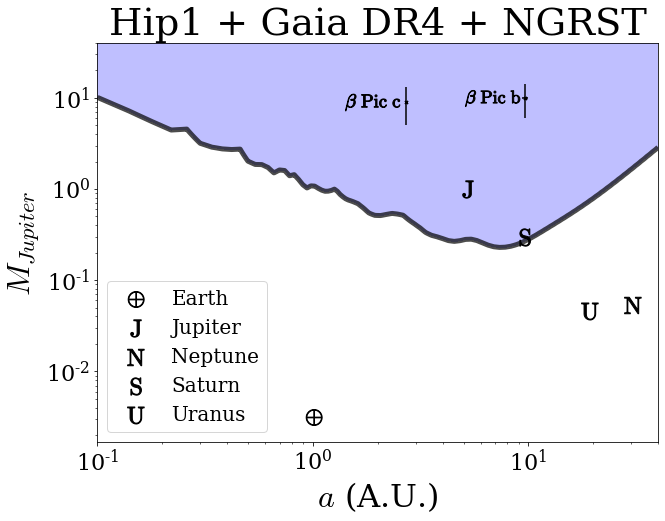

In [16]:
"""
Now we will use the calculated chisquareds to make a 2d contour plot of the data.
"""

###################
title_font_size = 28
tick_font_size = 32
######
# setting plot parameters
font = {'family' : 'serif',
        'size'   : tick_font_size}
plt.rc('font', **font)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('mathtext', fontset="cm") # fixing latex fonts
#######

def resample(x, y, num):
    f = interp1d(x, y, kind='linear')
    x_lin = np.linspace(np.min(x), np.max(x), num)
    return x_lin, f(x_lin)

separation_samples = 1000
mass_samples = 1000


fig, ax = plt.subplots(figsize=(10, 8))


# use the chisquareds and separations 
separations, chisqds = resample(separations, chisqds, separation_samples) # resample onto log grid
masses = np.linspace(1/600, 40, mass_samples) * u.M_jup

# generate chisquared array for all the masses
chisqds = np.ones((len(masses), len(separations)), dtype=float) * np.array(chisqds)
# apply the scaling with the astrometric signal (saves having to calculate the fit over the masses).
# This is why we do not calculate chisquared changes in the mass in the previous Cell of this notebook).
chisqds *= (((-masses / mass_star).decompose().value).reshape(-1, 1)) ** 2
masses = masses.value
# plotting contours
sigma_contour = np.sqrt(30)
X, Y = np.meshgrid(separations.flatten(), masses.flatten())
cs1 = ax.contour(X, Y, np.sqrt(chisqds), [sigma_contour], colors='black',
linestyles=['solid'], linewidths=5, alpha=0.7)
cs2 = ax.contourf(X, Y, np.sqrt(chisqds), [0, sigma_contour, 10000], extend='both',
                  colors=['w', 'b'], alpha=0.25)
cs2.cmap.set_under('w')
cs2.cmap.set_over('b')
ax.set_title(plot_title)
#ax.clabel(contours, inline=True, fontsize=20, fmt='%1.1f', manual=[(3, 1)], inline_spacing=0)

# plotting planets
solar_system = [{'mass': 1 / 317.8, 'a': 1, 'name': 'Earth', 'marker': r'$\oplus$'},
                {'mass': 1, 'a': 5.2, 'name': 'Jupiter', 'marker': r'${\rm J}$'},
                {'mass': 17.15 / 317.8, 'a': 30.11, 'name': 'Neptune', 'marker': r'${\rm N}$'},
                {'mass': 95.16 / 317.8, 'a': 9.55, 'name': 'Saturn', 'marker': r'${\rm S}$'},
                {'mass': 14.54 / 317.8, 'a': 19.2, 'name': 'Uranus', 'marker': r'${\rm U}$'}]
betapic = [{'mass': 10, 'a': 9.65, 'name': r'$\beta~{\rm Pic~b}$', 'marker': r'$\beta~{\rm Pic~b}$',
            'merr': 4, 'aerr': .3},
           {'mass': 9, 'a': 2.7, 'name': r'$\beta~{\rm Pic~c}$', 'marker': r'$\beta~{\rm Pic~c}$',
            'merr': 4, 'aerr': 0.02},
           ]

for planet in solar_system:
    ax.scatter(planet['a'], planet['mass'], marker=planet['marker'], color='k', label=planet['name'],
               s=300, zorder=9)

ax.legend(loc='lower left', prop={'size': 20})

for planet in betapic:
    ax.scatter(planet['a']*0.7, planet['mass'], marker=planet['marker'],
               color='k', label=planet['name'],
               s=3000, zorder=9)
    ax.scatter(planet['a'], planet['mass'], marker='x', color='k', s=10, zorder=9)
    ax.errorbar(planet['a'], planet['mass'],
                yerr=planet['merr'], xerr=planet['aerr'], zorder=9, color='k')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$M_{Jupiter}$')
ax.set_xlabel(r'$a$ (A.U.)')

plt.tight_layout()
plt.show()


## Example 5: Downloading GOST scanning law data through HTOF.
### HTOF data parsers provide an interface to the GOST scanning law directly, without a need to download the files from the web interface.
### Downloaded files are then saved in the intermediate data directory provided to the parser.

### You must provide the Hipparcos star ID. For instance, if we wanted Hip 49699, we would provide star_id=49699

In [17]:
gaia = GaiaeDR3()
gaia.parse(star_id=49699, intermediate_data_directory='./')
# the GOST csv file will be saved to intermediate_data_directory for future use. In this case, './'


### Now, not only is the gaia parser object ready to be used, the GOST csv file has been downloaded and saved in the root directory. See for yourself!

In [18]:
pd.read_csv('./HIP49699.csv').head(72)

,Target,ra[rad],dec[rad],ra[h:m:s],dec[d:m:s],ObservationTimeAtGaia[UTC],CcdRow[1-7],zetaFieldAngle[rad],scanAngle[rad],Fov[FovP=preceding/FovF=following],parallaxFactorAlongScan,parallaxFactorAcrossScan,ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]
0,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2014-10-21T06:24:42.159,2,0.004440,-1.890470,FOV2,-0.601076,0.710269,2.456952e+06
1,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2014-10-21T10:38:22.154,7,-0.006477,-1.897350,FOV1,-0.597773,0.714396,2.456952e+06
2,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2014-12-11T12:02:52.979,4,0.001671,-2.271084,FOV2,-0.558460,0.704131,2.457003e+06
3,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2015-04-30T23:47:45.296,5,-0.002871,-0.306680,FOV1,0.691931,0.718717,2.457143e+06
4,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2015-05-01T01:34:19.506,3,0.002372,-0.305949,FOV2,0.691232,0.719721,2.457144e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2018-06-02T06:26:33.952,6,-0.002623,-0.471371,FOV2,0.645054,0.720305,2.458272e+06
68,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2018-10-11T04:57:08.766,4,-0.001414,-1.922265,FOV1,-0.485383,0.717096,2.458403e+06
69,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2018-11-04T04:54:12.833,6,-0.004394,2.823746,FOV1,0.690371,0.715161,2.458427e+06
70,HIP49699,2.656038,0.59764,10:08:43.141,+34:14:32.147,2018-11-04T06:40:47.031,4,0.000717,2.821818,FOV2,0.691524,0.714291,2.458427e+06


### and compare to the csv file on disc, downloaded from the gost user interface by-hand

In [19]:
pd.read_csv('htof/test/data_for_tests/GaiaDR2/IntermediateData/HIP049699.csv')

,Target,ra[rad],dec[rad],ra[h:m:s],dec[d:m:s],ObservationTimeAtGaia[UTC],CcdRow[1-7],zetaFieldAngle[rad],scanAngle[rad],Fov[FovP=preceding/FovF=following],parallaxFactorAlongScan,parallaxFactorAcrossScan,ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]
0,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2014-10-21T06:24:42.159,2,0.004440,-1.890470,FoVF,-0.601076,0.710269,2.456952e+06
1,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2014-10-21T10:38:22.154,7,-0.006477,-1.897350,FoVP,-0.597773,0.714396,2.456952e+06
2,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2014-12-11T12:02:52.979,4,0.001671,-2.271084,FoVF,-0.558460,0.704131,2.457003e+06
3,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2015-04-30T23:47:45.296,5,-0.002871,-0.306680,FoVP,0.691931,0.718717,2.457143e+06
4,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2015-05-01T01:34:19.506,3,0.002372,-0.305949,FoVF,0.691232,0.719721,2.457144e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2018-06-02T06:26:33.952,6,-0.002623,-0.471371,FoVF,0.645054,0.720305,2.458272e+06
68,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2018-10-11T04:57:08.766,4,-0.001414,-1.922265,FoVP,-0.485383,0.717096,2.458403e+06
69,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2018-11-04T04:54:12.833,6,-0.004394,2.823746,FoVP,0.690371,0.715161,2.458427e+06
70,HIP 49699,2.656038,0.59764,10:08:43.141,+34:14:32.149,2018-11-04T06:40:47.031,4,0.000717,2.821818,FoVF,0.691524,0.714291,2.458427e+06
